In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import time
import os
import re
import warnings
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda")

## Loading data

In [4]:
df_train = pd.read_csv('/kaggle/input/sentiment-analysis-on-imdb-dataset-2025/train.csv')
x_train, y_train = df_train['review'].values, df_train['sentiment'].values
y_train = (y_train == 'positive').astype(int)

In [5]:
df_val = pd.read_csv('/kaggle/input/sentiment-analysis-on-imdb-dataset-2025/val.csv')
x_val, y_val = df_val['review'].values, df_val['sentiment'].values
y_val = (y_val == 'positive').astype(int)

In [6]:
df_test = pd.read_csv('/kaggle/input/sentiment-analysis-on-imdb-dataset-2025/test.csv')
x_test = df_test['review'].values

## Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
stopwords = nltk.corpus.stopwords.words("english")

def preprocessing_for_bert(data, max_len=512):

    def text_preprocessing(text):
        text = text.lower()
        text = re.sub(f' {stopwords[:63]} ', ' ', text)
        text = re.sub(r'(@.*?)[\s]', ' ', text)
        text = re.sub(r'&amp;', '&', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
     
    input_ids = []
    attention_masks = []

    for text in tqdm(data):

        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(text),  
            add_special_tokens=True,       
            max_length=max_len,                  
            pad_to_max_length=True,       
            truncation=True,         
            return_attention_mask=True 
            )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [8]:
train_inputs, train_masks = preprocessing_for_bert(x_train)
val_inputs, val_masks = preprocessing_for_bert(x_val)
test_inputs, test_masks = preprocessing_for_bert(x_test)

100%|██████████| 7500/7500 [00:37<00:00, 200.40it/s]


In [9]:
train_labels = torch.tensor(y_train, dtype=torch.float32)
val_labels = torch.tensor(y_val, dtype=torch.float32)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=1)

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

## Model

In [ ]:
bert = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
class BERTClassifier(nn.Module):
    
    def __init__(self, bert, device='cuda'):

        super(BERTClassifier, self).__init__()
        
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.silu =  nn.SiLU()
        self.fc1 = nn.Linear(768,128)
        self.fc2 = nn.Linear(128,1)
        self.sigmoid = nn.Sigmoid()
        self.best_accuracy = 0
        self.history = {'train_loss' : [], 'val_loss' : [], 'accuracy' : []}
        self.device = device
        self.to(device)

    def forward(self, x, mask):
  
        _, x = self.bert(x, attention_mask=mask).values()
        x = self.fc1(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

    def predict(self, data):
        
        self.eval()
        predictions = []
        
        with tqdm(total = len(data)) as tq:
            for batch in data:
                b_data = tuple(t.to(self.device) for t in batch)
                if len(b_data) == 3:
                    b_input_ids, b_attn_mask, b_labels = b_data
                else:
                    b_input_ids, b_attn_mask = b_data
                with torch.no_grad():
                    preds = self.forward(b_input_ids, b_attn_mask).cpu()
                predictions.extend(preds)
                tq.update(1)
                
        predictions = np.array(predictions).reshape(-1)
        
        return (predictions > 0.5).astype(int)

    def fit(self, train_dataloader, val_dataloader=None, epochs=5, early_stopping = None, evaluation=True, save_best=True):

        epochs_without_improvements = 0
        
        for epoch in range(epochs):
    
            t_start = time.time()
    
            total_loss = 0.
    
            self.train()
    
            with tqdm(total = len(train_dataloader)) as tq:
                
                for step, batch in enumerate(train_dataloader):
                    
                    self.optimizer.zero_grad()
                    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
                    b_labels = b_labels.reshape(-1,1)
                    pred = self.forward(b_input_ids, b_attn_mask)
                    loss = self.loss_fn(pred, b_labels)
                    loss_value = loss.item()
                    total_loss += loss_value
        
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                    self.optimizer.step()
                    self.scheduler.step()
                    tq.update(1)
                    tq.set_description("Loss %s" % loss_value)
            
    
            avg_train_loss = total_loss / len(train_dataloader)
            
            self.history['train_loss'].append(avg_train_loss)

            epochs_without_improvements += 1
    
            if evaluation == True:
    
                val_loss, val_accuracy = self.evaluate(val_dataloader)

                self.history['val_loss'].append(val_loss)
                self.history['accuracy'].append(val_accuracy)
    
                time_elapsed = time.time() - t_start
    
                
                if val_accuracy > self.best_accuracy:
                    self.best_accuracy = val_accuracy
                    epochs_without_improvements = 0
                    
                    if save_best:
                        self.save_checkpoint('best_ckpt.pt', epoch)
                        
                self.best_accuracy = max(self.best_accuracy, val_accuracy)
                
                print(f"{epoch + 1:^7} | {'-':^7} | train_loss {avg_train_loss:^12.6f} | val_loss {val_loss:^10.6f} | accuracy {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
    
            if early_stopping:
                if epochs_without_improvements == early_stopping:
                    break
                    
        self.save_checkpoint('last_ckpt.pt', epoch)

    def evaluate(self, val_dataloader):

        self.eval()
    
        val_accuracy = []
        val_loss = []
        
        with tqdm(total = len(val_dataloader)) as tq:
            
            for i, batch in enumerate(val_dataloader):
                
                b_input_ids, b_attn_mask, b_labels = tuple(t.to(self.device) for t in batch)
                b_labels = b_labels.reshape(-1,1)
                
                with torch.no_grad():
                    pred = self.forward(b_input_ids, b_attn_mask)
        
                loss = self.loss_fn(pred, b_labels)
                val_loss.append(loss.item())
        
                accuracy = ((pred>0.5) == b_labels).cpu().numpy().mean()
                val_accuracy.append(accuracy)
                
                tq.update(1)
    
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        return val_loss, val_accuracy
    
    def save_checkpoint(self, filename, epoch):
        state = {
            'epoch': epoch,
            'model': self,
            }
        torch.save(state, filename)

    def set_loss_fn(self, loss_fn):
        self.loss_fn = loss_fn

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_scheduler(self, scheduler):
        self.scheduler = scheduler

    
    def load_best_model(self, path='/kaggle/working/best_ckpt.pt'):
        ckpt = torch.load(path)
        print(f'Model loaded from epoch {ckpt["epoch"]}')
        return ckpt['model']

    def load_last_model(self, path='/kaggle/working/last_ckpt.pt'):
        ckpt = torch.load(path)
        print(f'Model loaded from epoch {ckpt["epoch"]}')
        return ckpt['model']

    def plot_history(self):
        fig, axs = plt.subplots(1,2,figsize=(12,4))
        axs[0].plot(self.history['train_loss'],label='train_loss')
        axs[0].plot(self.history['val_loss'],label='val_loss')
        axs[0].set_xlabel('epoch')
        axs[0].set_ylabel('loss')
        axs[0].legend()
        axs[1].plot(self.history['accuracy'])
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('accuracy')
        plt.show()
        
        

In [12]:
model = BERTClassifier(bert)

## Training

In [13]:
for param in model.bert.parameters():
    param.requires_grad = False

epochs = 20
early_stopping = 5

model.set_loss_fn(nn.BCELoss())
model.set_optimizer(AdamW(model.parameters(), lr = 5e-5, eps=1e-8))
total_steps = len(train_dataloader) * epochs
model.set_scheduler(get_linear_schedule_with_warmup(model.optimizer,
                                            num_warmup_steps = 0.1 * total_steps,
                                            num_training_steps = total_steps))

model.fit(train_dataloader, val_dataloader, epochs=epochs, evaluation=True, early_stopping=early_stopping)

100%|██████████| 7500/7500 [02:19<00:00, 53.77it/s]


   1    |    -    | train_loss   0.682101   | val_loss  0.661303  | accuracy   0.60    |  698.25  


100%|██████████| 7500/7500 [02:19<00:00, 53.80it/s]


   2    |    -    | train_loss   0.611611   | val_loss  0.569179  | accuracy   0.70    |  696.05  


100%|██████████| 7500/7500 [02:19<00:00, 53.81it/s]


   3    |    -    | train_loss   0.533052   | val_loss  0.487027  | accuracy   0.77    |  696.42  


100%|██████████| 7500/7500 [02:19<00:00, 53.77it/s]


   4    |    -    | train_loss   0.498149   | val_loss  0.461998  | accuracy   0.79    |  697.07  


100%|██████████| 7500/7500 [02:19<00:00, 53.73it/s]


   5    |    -    | train_loss   0.477919   | val_loss  0.448718  | accuracy   0.79    |  697.75  


100%|██████████| 7500/7500 [02:19<00:00, 53.69it/s]


   6    |    -    | train_loss   0.464133   | val_loss  0.437722  | accuracy   0.80    |  700.86  


100%|██████████| 7500/7500 [02:19<00:00, 53.69it/s]


   7    |    -    | train_loss   0.454522   | val_loss  0.412688  | accuracy   0.82    |  698.92  


100%|██████████| 7500/7500 [02:19<00:00, 53.67it/s]


   8    |    -    | train_loss   0.446423   | val_loss  0.405189  | accuracy   0.82    |  699.06  


100%|██████████| 7500/7500 [02:19<00:00, 53.64it/s]


   9    |    -    | train_loss   0.442372   | val_loss  0.399657  | accuracy   0.82    |  699.47  


100%|██████████| 7500/7500 [02:19<00:00, 53.63it/s]


  10    |    -    | train_loss   0.436670   | val_loss  0.396666  | accuracy   0.82    |  699.65  


100%|██████████| 7500/7500 [02:20<00:00, 53.57it/s]


  11    |    -    | train_loss   0.430393   | val_loss  0.390308  | accuracy   0.82    |  700.03  


100%|██████████| 7500/7500 [02:20<00:00, 53.46it/s]


  12    |    -    | train_loss   0.430054   | val_loss  0.389706  | accuracy   0.83    |  700.58  


100%|██████████| 7500/7500 [02:20<00:00, 53.48it/s]


  13    |    -    | train_loss   0.425933   | val_loss  0.387976  | accuracy   0.83    |  700.69  


100%|██████████| 7500/7500 [02:20<00:00, 53.48it/s]


  14    |    -    | train_loss   0.425062   | val_loss  0.384051  | accuracy   0.83    |  700.74  


100%|██████████| 7500/7500 [02:20<00:00, 53.45it/s]


  15    |    -    | train_loss   0.422455   | val_loss  0.385304  | accuracy   0.83    |  700.80  


100%|██████████| 7500/7500 [02:20<00:00, 53.48it/s]


  16    |    -    | train_loss   0.420232   | val_loss  0.381210  | accuracy   0.83    |  700.88  


100%|██████████| 7500/7500 [02:20<00:00, 53.35it/s]


  17    |    -    | train_loss   0.419207   | val_loss  0.379917  | accuracy   0.83    |  701.47  


100%|██████████| 7500/7500 [02:20<00:00, 53.47it/s]


  18    |    -    | train_loss   0.419040   | val_loss  0.381420  | accuracy   0.83    |  701.15  


100%|██████████| 7500/7500 [02:20<00:00, 53.45it/s]


  19    |    -    | train_loss   0.419896   | val_loss  0.378794  | accuracy   0.83    |  701.08  


100%|██████████| 7500/7500 [02:20<00:00, 53.44it/s]


  20    |    -    | train_loss   0.419384   | val_loss  0.379217  | accuracy   0.83    |  701.19  


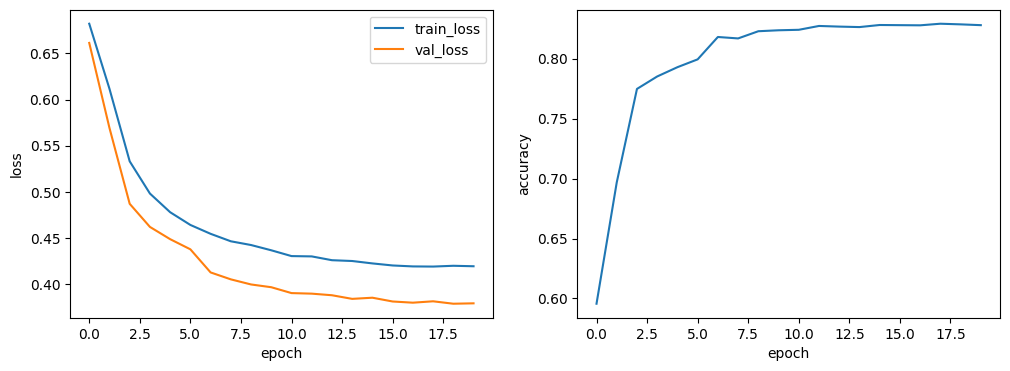

In [14]:
model.plot_history()

## Predict

In [18]:
model = model.load_best_model()

Model loaded from epoch 14


In [19]:
predictions = model.predict(test_dataloader)
predictions_df = pd.DataFrame({'ReviewId': range(1, len(predictions) + 1), 'Label': predictions})
predictions_df.to_csv('submission_best_model.csv', index=False)

100%|██████████| 7500/7500 [02:19<00:00, 53.76it/s]


In [20]:
model = model.load_last_model()

Model loaded from epoch 19


In [21]:
predictions = model.predict(test_dataloader)
predictions_df = pd.DataFrame({'ReviewId': range(1, len(predictions) + 1), 'Label': predictions})
predictions_df.to_csv('submission_last_model.csv', index=False)

100%|██████████| 7500/7500 [02:19<00:00, 53.73it/s]
